In [1]:
# ================================================================
#  AI-Powered Task Management System (Priority Prediction Only)
# ================================================================

In [2]:
# -------------------------------
#  1. Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, warnings
from wordcloud import WordCloud
import joblib

# NLP
import nltk, re, string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Ignore warnings
warnings.filterwarnings("ignore")


[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [3]:
# -------------------------------
#  2. Load Dataset
# -------------------------------
df = pd.read_csv("ai_powered_task_management_dataset.csv")
print("\n Dataset Loaded Successfully!")


 Dataset Loaded Successfully!


In [4]:
print(df.head())

   task_id                          task_name assigned_to department priority  \
0        1      Create marketing landing page         Eve    Backend   Medium   
1        2               Update mobile app UI       Grace      UI/UX     High   
2        3            Fix bug in login module      Hannah      UI/UX     High   
3        4  Implement user authentication API       David    Backend     High   
4        5      Improve page load performance      Hannah     DevOps   Medium   

        status created_date    due_date  estimated_hours  actual_hours  \
0  In Progress   04-08-2025  24-08-2025               16           NaN   
1  In Progress   22-06-2025  12-07-2025                7           NaN   
2      Pending   03-05-2025  07-05-2025               12           NaN   
3  In Progress   11-10-2025  15-10-2025                5           NaN   
4    Completed   13-07-2025  03-08-2025               12          11.0   

                                 tags  
0  optimization, deployment,

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   task_id          5000 non-null   int64  
 1   task_name        5000 non-null   object 
 2   assigned_to      5000 non-null   object 
 3   department       5000 non-null   object 
 4   priority         5000 non-null   object 
 5   status           5000 non-null   object 
 6   created_date     5000 non-null   object 
 7   due_date         5000 non-null   object 
 8   estimated_hours  5000 non-null   int64  
 9   actual_hours     1019 non-null   float64
 10  tags             5000 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 429.8+ KB
None


In [7]:
# -------------------------------
#  3. Data Cleaning
# -------------------------------

# Remove duplicate rows and rows with missing key fields ('task_name', 'priority')
df.drop_duplicates(inplace=True)
df.dropna(subset=['task_name', 'priority'], inplace=True)

# Convert date columns to datetime format (invalid formats will become NaT)
df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')
df['due_date'] = pd.to_datetime(df['due_date'], errors='coerce')

# Fill missing values in categorical columns with default placeholders
df.fillna({'status': 'Unknown', 'assigned_to': 'Unassigned'}, inplace=True)
print("\n Data Cleaning Done!")


 Data Cleaning Done!


In [8]:
# After cleaning 
print("\n Cleaned Dataset Info:")
print(df.info())


 Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   task_id          5000 non-null   int64         
 1   task_name        5000 non-null   object        
 2   assigned_to      5000 non-null   object        
 3   department       5000 non-null   object        
 4   priority         5000 non-null   object        
 5   status           5000 non-null   object        
 6   created_date     1991 non-null   datetime64[ns]
 7   due_date         5000 non-null   datetime64[ns]
 8   estimated_hours  5000 non-null   int64         
 9   actual_hours     1019 non-null   float64       
 10  tags             5000 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 429.8+ KB
None


In [9]:
# -------------------------------
#  4. Exploratory Data Analysis (EDA)
# -------------------------------
print("\n Dataset Summary:")
print(df.describe(include='all'))


 Dataset Summary:
            task_id                      task_name assigned_to department  \
count   5000.000000                           5000        5000       5000   
unique          NaN                             20           8          7   
top             NaN  Create marketing landing page         Eve      UI/UX   
freq            NaN                            291         667        751   
mean    2500.500000                            NaN         NaN        NaN   
min        1.000000                            NaN         NaN        NaN   
25%     1250.750000                            NaN         NaN        NaN   
50%     2500.500000                            NaN         NaN        NaN   
75%     3750.250000                            NaN         NaN        NaN   
max     5000.000000                            NaN         NaN        NaN   
std     1443.520003                            NaN         NaN        NaN   

       priority       status                   created_d

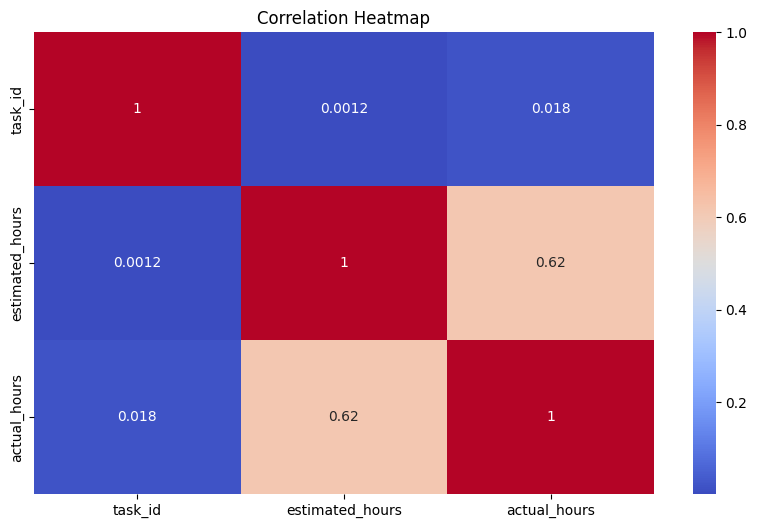

In [10]:
# Correlation heatmap (numerical features only)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

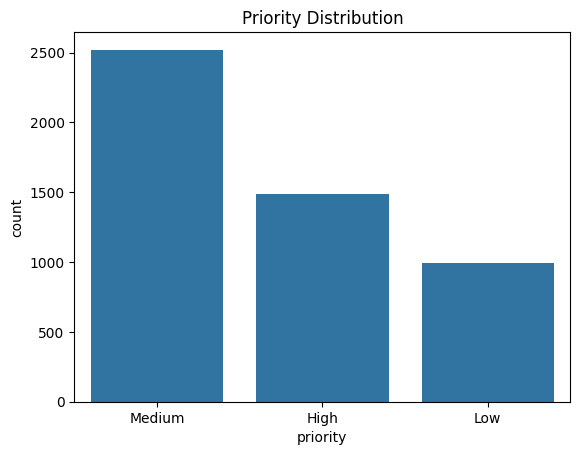

In [11]:
# Priority distribution
sns.countplot(x='priority', data=df)
plt.title("Priority Distribution")
plt.show()

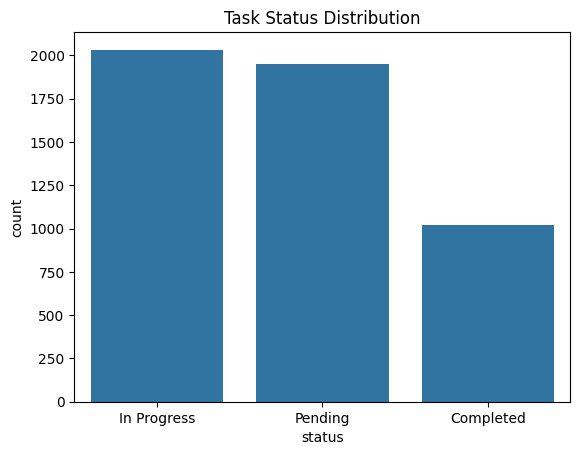

In [12]:
# Status distribution
sns.countplot(x='status', data=df)
plt.title("Task Status Distribution")
plt.show()


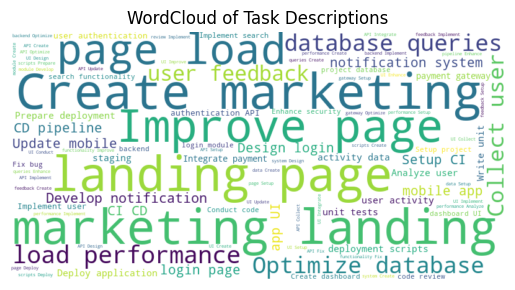

In [13]:
# Word Cloud of Task
text = " ".join(df['task_name'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Task Descriptions")
plt.show()

In [14]:
# -------------------------------
#  4. NLP Preprocessing (Stemming + Lemmatization)
# -------------------------------

# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()                                         # Lowercase all text
    text = re.sub(r'\d+', '', text)                             # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()                                       # Tokenize text
    tokens = [w for w in tokens if w not in stop_words]         # Remove stopwords
    
    # Apply Lemmatization followed by Stemming
    tokens = [stemmer.stem(lemmatizer.lemmatize(w)) for w in tokens]
    
    return " ".join(tokens)

# Combine multiple fields for richer NLP context
df["combined_text"] = (
    df["task_name"].astype(str) + " " +
    df["status"].astype(str) + " " +
    df["assigned_to"].astype(str) + " " +
    df["due_date"].astype(str)
)

# Apply preprocessing
df['clean_text'] = df['combined_text'].apply(preprocess_text)

print("\n NLP Preprocessing (Stemming + Lemmatization) Completed Successfully!")


 NLP Preprocessing (Stemming + Lemmatization) Completed Successfully!


In [15]:
# -------------------------------
#  5. TF-IDF Feature Extraction
# -------------------------------
tfidf = TfidfVectorizer(max_features=4000)
X_text = tfidf.fit_transform(df['clean_text']).toarray()

In [16]:
# ================================================================
#  6. TASK CLASSIFICATION (Naive Bayes & SVM)
# ================================================================
print("\n TASK CLASSIFICATION: Naive Bayes & SVM")

#  Define feature text
X_text = df['clean_text']   # or df['combined_text'] if you prefer

# Encode target labels (task names)
le_task = LabelEncoder()
y_task = le_task.fit_transform(df['task_name'])

# Split data
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_text, y_task, test_size=0.2, random_state=42
)


#  TF-IDF Vectorization  (Convert text to numeric features)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_t = vectorizer.fit_transform(X_train_t)
X_test_t = vectorizer.transform(X_test_t)

#  Naive Bayes Classifier
nb = MultinomialNB()
nb.fit(X_train_t, y_train_t)
y_pred_nb = nb.predict(X_test_t)

#  SVM Classifier
svm = LinearSVC()
svm.fit(X_train_t, y_train_t)
y_pred_svm = svm.predict(X_test_t)

#  Evaluation
nb_acc = accuracy_score(y_test_t, y_pred_nb)
nb_prec = precision_score(y_test_t, y_pred_nb, average='weighted', zero_division=0)
nb_rec = recall_score(y_test_t, y_pred_nb, average='weighted', zero_division=0)
nb_f1 = f1_score(y_test_t, y_pred_nb, average='weighted')

svm_acc = accuracy_score(y_test_t, y_pred_svm)
svm_prec = precision_score(y_test_t, y_pred_svm, average='weighted', zero_division=0)
svm_rec = recall_score(y_test_t, y_pred_svm, average='weighted', zero_division=0)
svm_f1 = f1_score(y_test_t, y_pred_svm, average='weighted')

print("\n Naive Bayes Metrics:")
print(f"Accuracy: {nb_acc:.4f} | Precision: {nb_prec:.4f} | Recall: {nb_rec:.4f} | F1: {nb_f1:.4f}")

print("\n SVM Metrics:")
print(f"Accuracy: {svm_acc:.4f} | Precision: {svm_prec:.4f} | Recall: {svm_rec:.4f} | F1: {svm_f1:.4f}")

#  Model Comparison
task_results = pd.DataFrame({
    "Model": ["Naive Bayes", "SVM"],
    "Accuracy": [nb_acc, svm_acc],
    "Precision": [nb_prec, svm_prec],
    "Recall": [nb_rec, svm_rec],
    "F1 Score": [nb_f1, svm_f1]
})
print("\n Task Classification Model Comparison:\n", task_results)

best_task_model = "Naive Bayes" if nb_f1 > svm_f1 else "SVM"
print(f"\n Best Task Classification Model → {best_task_model}")



 TASK CLASSIFICATION: Naive Bayes & SVM

 Naive Bayes Metrics:
Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000

 SVM Metrics:
Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000

 Task Classification Model Comparison:
          Model  Accuracy  Precision  Recall  F1 Score
0  Naive Bayes       1.0        1.0     1.0       1.0
1          SVM       1.0        1.0     1.0       1.0

 Best Task Classification Model → SVM


In [17]:
# ================================================================
#  7. PRIORITY PREDICTION (Random Forest with Tuning)
# ================================================================
print("\n PRIORITY PREDICTION: Random Forest with Tuning")

le_priority = LabelEncoder()
y_priority = le_priority.fit_transform(df['priority'])

# Balance dataset if imbalanced
priority_counts = df['priority'].value_counts()
min_count = priority_counts.min()

if priority_counts.max() > 2 * min_count:
    print("\n Balancing priority classes...")
    df_majority = df[df['priority'] == priority_counts.idxmax()]
    df_minority = df[df['priority'] != priority_counts.idxmax()]
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
    df_bal = pd.concat([df_majority, df_minority_upsampled])
else:
    df_bal = df

X_bal = tfidf.fit_transform(df_bal['clean_text']).toarray()
y_bal = le_priority.fit_transform(df_bal['priority'])

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

# --- Random Forest + GridSearchCV ---
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
grid = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                    param_grid, cv=3, scoring='f1_weighted')
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)

# --- Evaluation ---
def evaluate_model(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, average='weighted')
    }

rf_metrics = evaluate_model(y_test, y_pred)
print("\n Random Forest Best Params:", grid.best_params_)
print(f"\n Priority Prediction Metrics: {rf_metrics}")



 PRIORITY PREDICTION: Random Forest with Tuning

 Balancing priority classes...

 Random Forest Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

 Priority Prediction Metrics: {'Accuracy': 0.41625371655104065, 'Precision': 0.467251278411412, 'Recall': 0.41625371655104065, 'F1 Score': 0.42514612760460063}


In [18]:
#  Save the Model
joblib.dump(best_rf, "best_priority_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(le_priority, "label_encoder_priority.pkl")
print("\n Model Saved Successfully!")



 Model Saved Successfully!


In [19]:
# ================================================================
#  8. TEST NEW TASKS (Prediction)
# ================================================================
print("\n Testing with New Tasks")

# Load saved models
tfidf = joblib.load("tfidf_vectorizer.pkl")
priority_model = joblib.load("best_priority_model.pkl")
le_priority = joblib.load("label_encoder_priority.pkl")

new_tasks = [
    "Create marketing landing page",
    "Prepare project report presentation for next week",
    "Update client database and backup files",
    "Schedule team meeting to discuss deadlines"
]

# Preprocess new data
clean_new_tasks = [preprocess_text(t) for t in new_tasks]
X_new = tfidf.transform(clean_new_tasks).toarray()

# Predict priority
priority_preds = priority_model.predict(X_new)
priority_labels = le_priority.inverse_transform(priority_preds)

# Show results
for t, priority_label in zip(new_tasks, priority_labels):
    print("\n Task:", t)
    print(" Predicted Priority:", priority_label)
    print("-" * 60)



 Testing with New Tasks

 Task: Create marketing landing page
 Predicted Priority: High
------------------------------------------------------------

 Task: Prepare project report presentation for next week
 Predicted Priority: Low
------------------------------------------------------------

 Task: Update client database and backup files
 Predicted Priority: Medium
------------------------------------------------------------

 Task: Schedule team meeting to discuss deadlines
 Predicted Priority: Medium
------------------------------------------------------------


In [ ]:
# ================================================================
#  9. USER ASSIGNMENT MODEL (Machine Learning-based)
# ================================================================
print("\n USER ASSIGNMENT MODEL: Training model to predict task assignee")

# Ensure dataset has a valid 'assigned_to' column
if 'assigned_to' not in df.columns:
    raise KeyError("Dataset must have an 'assigned_to' column for user assignment training.")

# Filter out unassigned tasks
df_user = df[df['assigned_to'].notna() & (df['assigned_to'] != 'Unassigned')].copy()

# Encode target labels (users)
le_user = LabelEncoder()
df_user['user_encoded'] = le_user.fit_transform(df_user['assigned_to'])

# Combine task features (use clean_text + priority)
X_user = df_user['clean_text']
y_user = df_user['user_encoded']

# TF-IDF Vectorization
tfidf_user = TfidfVectorizer(max_features=4000, ngram_range=(1, 2))
X_user_vec = tfidf_user.fit_transform(X_user)

# Split data
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
    X_user_vec, y_user, test_size=0.2, random_state=42
)

# Train model (Random Forest works well for multi-class)
rf_user = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_user.fit(X_train_u, y_train_u)
y_pred_u = rf_user.predict(X_test_u)

# Evaluate performance
acc_user = accuracy_score(y_test_u, y_pred_u)
prec_user = precision_score(y_test_u, y_pred_u, average='weighted', zero_division=0)
rec_user = recall_score(y_test_u, y_pred_u, average='weighted', zero_division=0)
f1_user = f1_score(y_test_u, y_pred_u, average='weighted')

print(f"\n User Assignment Model Performance:")
print(f"Accuracy: {acc_user:.4f} | Precision: {prec_user:.4f} | Recall: {rec_user:.4f} | F1: {f1_user:.4f}")

# Save model & encoders
joblib.dump(rf_user, "user_assignment_model.pkl")
joblib.dump(tfidf_user, "tfidf_user.pkl")
joblib.dump(le_user, "label_encoder_user.pkl")
print("\n User Assignment Model Saved Successfully!")



 USER ASSIGNMENT MODEL: Training model to predict task assignee

 User Assignment Model Performance:
Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000

 User Assignment Model Saved Successfully!


In [39]:
# ================================================================
#  10. TEST NEW TASKS → PRIORITY + USER ASSIGNMENT (Combined)
# ================================================================
print("\nTask Management System")
print("--------------------------------------------------")

import joblib
import pandas as pd

# Load saved models
tfidf_priority = joblib.load("tfidf_vectorizer.pkl")
priority_model = joblib.load("best_priority_model.pkl")
le_priority = joblib.load("label_encoder_priority.pkl")

tfidf_user = joblib.load("tfidf_user.pkl")
user_model = joblib.load("user_assignment_model.pkl")
le_user = joblib.load("label_encoder_user.pkl")

# New incoming tasks
new_tasks = [
    "Create marketing landing page",
    "Prepare project report presentation for next week",
    "Update client database and backup files",
    "Schedule team meeting to discuss deadlines"
]

# Priority Prediction
clean_new_tasks = [preprocess_text(t) for t in new_tasks]
X_new_priority = tfidf_priority.transform(clean_new_tasks)
priority_preds = priority_model.predict(X_new_priority)
priority_labels = le_priority.inverse_transform(priority_preds)

# User Assignment Prediction
X_new_user = tfidf_user.transform(clean_new_tasks)
user_preds = user_model.predict(X_new_user)
user_labels = le_user.inverse_transform(user_preds)

# Display results
print("\nPredicted Priority and Task Assignments :")
for t, p, u in zip(new_tasks, priority_labels, user_labels):
    print(f"\nTask: {t}")
    print(f"Priority: {p}")
    print(f"Assigned To: {u}")
    print("-" * 50)

# Final Summary Table
results_df = pd.DataFrame({
    "Task": new_tasks,
    "Predicted Priority": priority_labels,
    "Assigned User": user_labels
})



Task Management System
--------------------------------------------------

Predicted Priority and Task Assignments :

Task: Create marketing landing page
Priority: High
Assigned To: Eve
--------------------------------------------------

Task: Prepare project report presentation for next week
Priority: Low
Assigned To: Bob
--------------------------------------------------

Task: Update client database and backup files
Priority: Medium
Assigned To: Bob
--------------------------------------------------

Task: Schedule team meeting to discuss deadlines
Priority: Medium
Assigned To: Bob
--------------------------------------------------
